# **Optimizing Compositional AUROC loss on imbalanced dataset**
 **Author**: Zhuoning Yuan

**Introduction**

In this tutorial, we will learn how to quickly train a ResNet20 model by optimizing AUC score using our novel compositional training framework [[Ref]](https://openreview.net/forum?id=gPvB4pdu_Z) on an binary image classification task on Cifar10. After completion of this tutorial, you should be able to use LibAUC to train your own models on your own datasets.  

**Useful Resources**

* Website: https://libauc.org
* Github: https://github.com/Optimization-AI/LibAUC


**References**

If you find this tutorial helpful in your work,  please acknowledge our library and cite the following papers:
<pre>
@inproceedings{yuan2022compositional,
    title={Compositional Training for End-to-End Deep AUC Maximization},
    author={Zhuoning Yuan and Zhishuai Guo and Nitesh Chawla and Tianbao Yang},
    booktitle={International Conference on Learning Representations},
    year={2022},
    url={https://openreview.net/forum?id=gPvB4pdu_Z}
}
</pre>


# **Installing LibAUC**
Let's start with install our library here. In this tutorial, we will use version `1.2.0`.

In [ ]:
!pip install libauc==1.2.0

# **Importing LibAUC**

Import required packages to use



In [ ]:
from libauc.losses import CompositionalAUCLoss
from libauc.optimizers import PDSCA
from libauc.models import resnet20 as ResNet20
from libauc.datasets import CIFAR10, CIFAR100, STL10, CAT_VS_DOG
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# **Reproducibility**

The following function `set_all_seeds` limits the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [ ]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip` as stated in the original paper. 


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target

## **Introduction for Loss and Optimizer**

In this section, we will introduce how to utilize `CompositonalAUCLoss` function and `PDSCA` optimizer.  

#### **CompositonalAUCLoss**
The objective function for `CompositonalAUCLoss` is defined as

$$\min _{\mathbf{w}} L_{\mathrm{AUC}}\left(\mathbf{w}-\alpha \nabla L_{\mathrm{CE}}(\mathbf{w})\right)$$
which is implemented as `CompositionalAUCLoss()` function that consists of two loss `CrossEntropyLoss` (with sigmoid) and `AUCMLoss`. For the details of `AUCMLoss`, please refer to this [tutorial](https://github.com/Optimization-AI/LibAUC/blob/main/examples/02_Optimizing_AUROC_with_ResNet20_on_Imbalanced_CIFAR10.ipynb) and the [paper](https://arxiv.org/pdf/2012.03173.pdf).

**PDSCA** is proposed and used to optimize the above objective function. For itearton $t$, the key updates are as follows: 

1.  $ \mathbf{u}_{t+1}=(1-\beta_{0}) \mathbf{u}_{t}+\beta_{0}(\mathbf{w}_{\mathbf{t}}-\eta_0 \nabla L_{CE}(\mathbf{w}_{\mathbf{t}}) ; a ; b)$ 
2. $ \mathbf{z}_{t+1}=(1-\beta_{1}) \mathbf{z}_{t}+\beta_{1} \nabla_{\mathbf{u}} L_{AUC}(\mathbf{u}_{t+1})$ 
3. $ \mathbf{v}_{t+1}=\mathbf{v}_{t}-\eta_{1} (\mathbf{z}_{t+1}$ + $λ_0(\mathbf{w}_t-\mathbf{v}_{ref})+ λ_1\mathbf{v}_t$) 
4. $ \theta_{t+1}=\theta_{t}+\eta_{1} \nabla_{\theta} L_{AUC}(\theta_{t})$

where $\lambda_0,\lambda$ refer to `epoch_decay` and `weight_decay`, $\eta_0,\eta$ refer to learning rates for inner updates ($L_{CE}$) and outer updates ($L_{AUC}$), and $\mathbf v_t$ refers to $\{\mathbf w_t, a_t, b_t\}$ and $θ$ refers to dual variable in `AUCMLoss`. For more details, please refer to the paper [[ref]](https://openreview.net/pdf?id=gPvB4pdu_Z).

## **Hyper-parameters**

**DualSampler**
  - `batch_size`: how many samples per mini-batch used for training model 
  - `sampling_rate`: the oversampling ratio for the positive minority class (default: 0.0)
  
**Loss**
 - `margin`: margin for surrogate loss (i.e., squred hinge loss). It is intergrated with optimizer (default: 1.0)
 - `last_activation`: activation function on model's outputs for AUC loss, i.e., 'sigmoid', 'l2', None (default: 'sigmoid')
 
**Optimizer**
  - `lr`: learning rate
  - `lr0`: learning rate refers to $\alpha$ in step (1) (default: `lr`)
  - `epoch_decay`: epoch decay (L2 penalty for epoch-level regularization) (default: 2e-3)
  - `weight_decay`: weight decay (L2 penalty) (default: 1e-4)
  - `beta0`: parameter for moving average in step (1) (Default: 0.9)
  - `beta1`: parameter for moving average in step (2) (Default: 0.999)

## **Useful Tips**
- You can tune `sampling_rate` in (0, 0.5] when data is imbalanced
- Use smaller `lr0` and larger `lr` can achieve good performance in some cases, e.g., `lr0=0.05`, `lr=0.1`
- Don not include `sigmoid` activation before computing loss. The `CompositionalAUCLoss()` already includes `sigmoid`, `l2` activation 
- To manually update `lr` you can do `optimizer.param_groups[0]['lr'] = self.param_groups[0]['lr']/decay_factor`. Similar to `lr0`, you can modify `optimizer.param_groups[0]['lr0']`

In [ ]:
# HyperParameters
SEED = 123
dataset = 'C10'
imratio = 0.1
BATCH_SIZE = 128
total_epochs = 100 
decay_epochs=[int(total_epochs*0.5), int(total_epochs*0.75)]

margin = 1.0
lr = 0.1  
#lr0 = 0.1 # (default: lr0=lr unless you specify the value and pass it to optimizer)
epoch_decay = 2e-3 
weight_decay = 1e-4
beta0 = 0.9   # e.g., [0.999, 0.99, 0.9]
beta1 = 0.9   # e.g., [0.999, 0.99, 0.9] 

sampling_rate = 0.2

# **Loading datasets**

In this step, we will use the [CIFAR10](http://yann.lecun.com/exdb/mnist/) as benchmark dataset. Before importing data to `dataloader`, we construct imbalanced version for CIFAR10 by `ImbalanceGenerator`. Specifically, it first randomly splits the training data by class ID (e.g., 10 classes) into two even portions as the positive and negative classes, and then it randomly removes some samples from the positive class to make
it imbalanced. We keep the testing set untouched. We refer `imratio` to the ratio of number of positive examples to number of all examples. 

In [ ]:
if dataset == 'C10':
    IMG_SIZE = 32
    train_data, train_targets = CIFAR10(root='./data', train=True)
    test_data, test_targets  = CIFAR10(root='./data', train=False)
elif dataset == 'C100':
    IMG_SIZE = 32
    train_data, train_targets = CIFAR100(root='./data', train=True)
    test_data, test_targets  = CIFAR100(root='./data', train=False)
elif dataset == 'STL10':
    BATCH_SIZE = 32
    IMG_SIZE = 96
    train_data, train_targets = STL10(root='./data/', split='train')
    test_data, test_targets = STL10(root='./data/', split='test')
elif dataset == 'C2':
    IMG_SIZE = 50
    train_data, train_targets  = CAT_VS_DOG('./data/', train=True)
    test_data, test_targets = CAT_VS_DOG('./data/', train=False)

(train_images, train_labels) = ImbalancedDataGenerator(verbose=True, random_seed=0).transform(train_data, train_targets, imratio=imratio)
(test_images, test_labels) = ImbalancedDataGenerator(verbose=True, random_seed=0).transform(test_data, test_targets, imratio=0.5) 

trainSet = ImageDataset(train_images, train_labels, image_size=IMG_SIZE, crop_size=IMG_SIZE-2)
trainSet_eval = ImageDataset(train_images, train_labels, image_size=IMG_SIZE, crop_size=IMG_SIZE-2, mode='test')
testSet = ImageDataset(test_images, test_labels, image_size=IMG_SIZE, crop_size=IMG_SIZE-2, mode='test')

# parameters for sampler
sampler = DualSampler(trainSet, batch_size=BATCH_SIZE, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, num_workers=2)
trainloader_eval = torch.utils.data.DataLoader(trainSet_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
#SAMPLES: [27777], POS:NEG: [2777 : 25000], POS RATIO: 0.1000
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


# **Model, Loss & Optimizer**
Before training, we need to define **model**, **loss function**, **optimizer**. 

In [ ]:
set_all_seeds(123)
model = ResNet20(pretrained=False, last_activation=None, activations='relu', num_classes=1)
model = model.cuda()
    
# Compositional Training
loss_fn = CompositionalAUCLoss()  
optimizer = PDSCA(model, 
                  loss_fn=loss_fn,
                  lr=lr,
                  beta1=beta0,
                  beta2=beta1, 
                  margin=margin, 
                  epoch_decay=epoch_decay, 
                  weight_decay=weight_decay)

# **Training**
Now it's time for training


In [ ]:
print ('Start Training')
print ('-'*30)

train_log = []
test_log = []
for epoch in range(total_epochs):
     if epoch in decay_epochs:
         optimizer.update_regularizer(decay_factor=10, decay_factor0=10) # decrease learning rate by 10x & update regularizer
   
     train_loss = []
     model.train()    
     for data, targets in trainloader:
         data, targets  = data.cuda(), targets.cuda()
         y_pred = model(data)
         loss = loss_fn(y_pred, targets)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         train_loss.append(loss.item())
    
     # evaluation on train & test sets
     model.eval()
     train_pred_list = []
     train_true_list = []
     for train_data, train_targets in trainloader_eval:
         train_data = train_data.cuda()
         train_pred = model(train_data)
         train_pred_list.append(train_pred.cpu().detach().numpy())
         train_true_list.append(train_targets.numpy())
     train_true = np.concatenate(train_true_list)
     train_pred = np.concatenate(train_pred_list)
     train_auc = auc_roc_score(train_true, train_pred)
     train_loss = np.mean(train_loss)
  
     test_pred_list = []
     test_true_list = [] 
     for test_data, test_targets in testloader:
         test_data = test_data.cuda()
         test_pred = model(test_data)
         test_pred_list.append(test_pred.cpu().detach().numpy())
         test_true_list.append(test_targets.numpy())
     test_true = np.concatenate(test_true_list)
     test_pred = np.concatenate(test_pred_list)
     val_auc =  auc_roc_score(test_true, test_pred) 
     model.train()
 
     # print results
     print("epoch: %s, train_loss: %.4f, train_auc: %.4f, test_auc: %.4f, lr: %.4f"%(epoch, train_loss, train_auc, val_auc, optimizer.lr ))    
     train_log.append(train_auc) 
     test_log.append(val_auc)     

Start Training
------------------------------
epoch: 0, train_loss: 0.3187, train_auc: 0.6465, test_auc: 0.6550, lr: 0.1000
epoch: 1, train_loss: 0.2997, train_auc: 0.6989, test_auc: 0.6943, lr: 0.1000
epoch: 2, train_loss: 0.2904, train_auc: 0.7293, test_auc: 0.7111, lr: 0.1000
epoch: 3, train_loss: 0.2812, train_auc: 0.7472, test_auc: 0.7395, lr: 0.1000
epoch: 4, train_loss: 0.2711, train_auc: 0.7793, test_auc: 0.7615, lr: 0.1000
epoch: 5, train_loss: 0.2611, train_auc: 0.7584, test_auc: 0.7404, lr: 0.1000
epoch: 6, train_loss: 0.2546, train_auc: 0.7873, test_auc: 0.7587, lr: 0.1000
epoch: 7, train_loss: 0.2464, train_auc: 0.7959, test_auc: 0.7642, lr: 0.1000
epoch: 8, train_loss: 0.2387, train_auc: 0.8436, test_auc: 0.8097, lr: 0.1000
epoch: 9, train_loss: 0.2336, train_auc: 0.7974, test_auc: 0.7664, lr: 0.1000
epoch: 10, train_loss: 0.2257, train_auc: 0.8126, test_auc: 0.7795, lr: 0.1000
epoch: 11, train_loss: 0.2202, train_auc: 0.8521, test_auc: 0.8198, lr: 0.1000
epoch: 12, train

# **Visualization**

Now, let's see the change of AUC scores on training and testing set. 


Text(0.5, 0, 'Epoch')

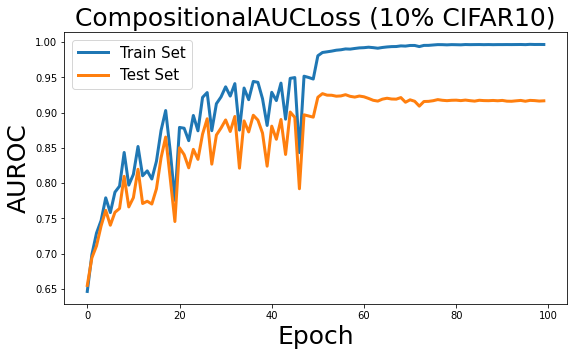

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, LineStyle='-', label='Train Set', linewidth=3)
plt.plot(x, test_log,  LineStyle='-', label='Test Set', linewidth=3)
plt.title('CompositionalAUCLoss (10% CIFAR10)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)